# Variability of dissolved inorganic carbon in the largest karst estuarine lagoon system of the southern Gulf of Mexico

### José Andrés Martínez-Trejo<sup>1</sup>, Jose-Gilberto Cardoso-Mohedano<sup>2,*</sup>, Joan Albert Sanchez-Cabeza<sup>3</sup>, José Martin Hernández Ayón<sup>4</sup>, Ana Carolina Ruiz-Fernández<sup> 3 </sup>, Mario Alejandro Gómez-Ponce <sup>2</sup> , Linda Barranco-Servín<sup>5</sup>, Daniel Pech<sup>5</sup>

<sup> 1 </sup> Posgrado en Ciencias del Mar y Limnología, Universidad Nacional Autónoma de México; Avenida Ciudad Universitaria 3000, C.P. 04510, Coyoacán, Ciudad de México, México

<sup> 2 </sup>  Estación el Carmen, Instituto de Ciencias del Mar y Limnología, Universidad Nacional Autónoma de México, Carretera Carmen-Puerto Real km. 9.5, 24157 Ciudad del Carmen, Campeche, México

<sup> 3 </sup>  Unidad Académica Mazatlán, Instituto de Ciencias del Mar y Limnología, Universidad Nacional Autónoma de México, Calzada Joel Montes Camarena s/n, Colonia Playa Sur, Mazatlán 82000, Sinaloa, México

<sup> 4 </sup>  Instituto de Investigaciones Oceanológicas, Universidad Autónoma de Baja California, Km. 103 CarreteraTijuana-Ensenada, Ensenada, Baja California, México

<sup> 5 </sup> Laboratorio de Biodiversidad Marina y Cambio Climático (BIOMARCCA), El Colegio de la Frontera Sur, Lerma, Campeche, México. 

 \*Corresponding Author: gcardoso@cmarl.unam.mx Phone:+52-938-38-31847

[doi:XXXXX](https://XXXX)


- Raw data are aviable in: 

https://metadata.icmyl.unam.mx/bitstream/handle/20.500.12201/11367/MartinezTrejo_etal_2023_TA_DIC_RawData.csv?sequence=1&isAllowed=y



- Read csv  data file

In [3]:
# Import packages
import pandas as pd
import PyCO2SYS as pyco2
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# Function to read in csv file
def read_csv(file):
    """
    Read in csv file and return pandas dataframe
    """
    df = pd.read_csv(file, sep=",", header=0,  decimal=".", encoding='utf-8')
    return df

In [5]:
# define file path 
terminos_ta_dic_data_path = "../data/MartinezTrejo_etal_2023_TA_DIC_RawData.csv"

# Read in data
terminos_ta_dic_data = read_csv(terminos_ta_dic_data_path)

# Copy data to new dataframe
terminos_ta_dic = terminos_ta_dic_data.copy()

### Calculate TA-DIC 

In [6]:
#Calculate the difference between DIC and TA
terminos_ta_dic["TA-DIC"]=  terminos_ta_dic["TA_micromol_kg"] - terminos_ta_dic["DIC_micromol_kg"]


## PyCO2SYS configuration from estuarine waters (Humphreys et al. 2022)

In [7]:
# Copy data to new dataframe
terminos_inorganic_carbon = terminos_ta_dic.copy()

# Create dictionary with data configuration for PyCO2SYS. 
# For more information on the parameters see Humphreys et al (2022)
my_co2sys_params_dic_ta_config = {
    # DIC measured in the lab in μmol/kg-sw
    "par1": terminos_inorganic_carbon["DIC_micromol_kg"],
    # TA measured in the lab, Total scale
    "par2": terminos_inorganic_carbon["TA_micromol_kg"],
    "par1_type": 2,         # tell PyCO2SYS: "par2 is a DIC value"
    "par2_type": 1,         # tell PyCO2SYS: "par1 is a TA value"
    # Fields conditions
    "salinity": terminos_inorganic_carbon["Sal_psu"],  # in-situ salinity in PSU
    # in-situ temperature (output conditions) in °C
    "temperature_out": terminos_inorganic_carbon["Temp_C"],
    "pressure_out": 0.0,
    # Settings
    "opt_pH_scale": 1,     # Total pH (Wolf-Gladrow et al. 2007)
    "opt_k_carbonic": 15,     # 0 < T < 50 °C, 1 < S < 50, Seawater scale, real seawater (Millero F.J. 2010)
    "temperature": 25      # lab temperature (input conditions) in °C
}

### Run PyCO2SYS

In [8]:
# Run PyCO2SYS to calculate the carbonate system parameters
terminos_inorganic_carbon_results= pyco2.sys(**my_co2sys_params_dic_ta_config)

### Read the interes variables from PYCO2sys 

In [9]:
# Select variables of interest from the PyCO2SYS output and create a DataFrame
pyco2_interest_variables = pd.DataFrame({
       "pH": terminos_inorganic_carbon_results["pH"],
       "saturation_aragonite": terminos_inorganic_carbon_results["saturation_aragonite"],
       "pCO2_atm": terminos_inorganic_carbon_results["pCO2_out"],
       "k_aragonite": terminos_inorganic_carbon_results["k_aragonite"],
       "total_calcium": terminos_inorganic_carbon_results["total_calcium"],
       "carbonate": terminos_inorganic_carbon_results["carbonate"]
       
})

# Concatenate PyCO2SYS output with the original dataframe
CarbonateTL = pd.concat([terminos_ta_dic, pyco2_interest_variables], axis=1)

### Select Candelaria and Palizada results

In [10]:
CandelariaResult = CarbonateTL.loc[CarbonateTL["Estuary"] == "Candelaria"]
                     
PalizadaResult = CarbonateTL.loc[CarbonateTL["Estuary"] == "Palizada"]

In [11]:
#create your own color array (viridis)
my_colors = ["#35b779", "#3e4989"]
sns.set_theme(font_scale=2, style="ticks", palette= my_colors)


In [12]:
def plot_variables(data, variable_dict):
    """
    Plot each variable by Area, colored by Season, for each Estuary.

    Parameters:
    data (pandas.DataFrame): DataFrame containing the data
    variable_dict (dict): Dictionary where keys are variable names and values are dictionaries with display names, min, and max values

    Returns:
    None
    """
    n = len(variable_dict)
    estuaries = data["Estuary"].unique()
    m = len(estuaries)

    fig, axs = plt.subplots(n, m, figsize=(7*m, 7*n))

    for i, variable in enumerate(variable_dict.keys()):
        display_name = variable_dict[variable]["display_name"]
        min_y = variable_dict[variable]["min"]
        max_y = variable_dict[variable]["max"]

        for j, estuary in enumerate(estuaries):
            ax = axs[i, j]
            sns.boxplot(x="Area", y=variable,
                        hue="Season", 
                        data=data[data["Estuary"] == estuary],
                        ax=ax,
                        palette= my_colors)  # Use 'viridis' color palette

            ax.set(xlabel='', ylabel=display_name)
            ax.set_ylim(min_y, max_y)  # Set the y-axis limits for each subplot
            if i == 0 and j == 0:
                ax.legend(title="Season", title_fontsize=20)
            else:
                ax.get_legend().remove()
            ax.set_title(estuary)

            sns.despine(top=False,right=False)

    plt.tight_layout()

In [13]:
measured_variables_dict = {
    "Sal_psu": {
        "display_name": "Salinity",
        "min": -1,
        "max": 40
    },
    "TA_micromol_kg": {
        "display_name": f'TA ($\mu mol \; kg^{{-1}}$)',
        "min": 2300,
        "max": 4400
    },
    "DIC_micromol_kg": {
        "display_name": f'DIC ($\mu mol \; kg^{{-1}}$)',
        "min": 2100,
        "max": 4400
    }
}

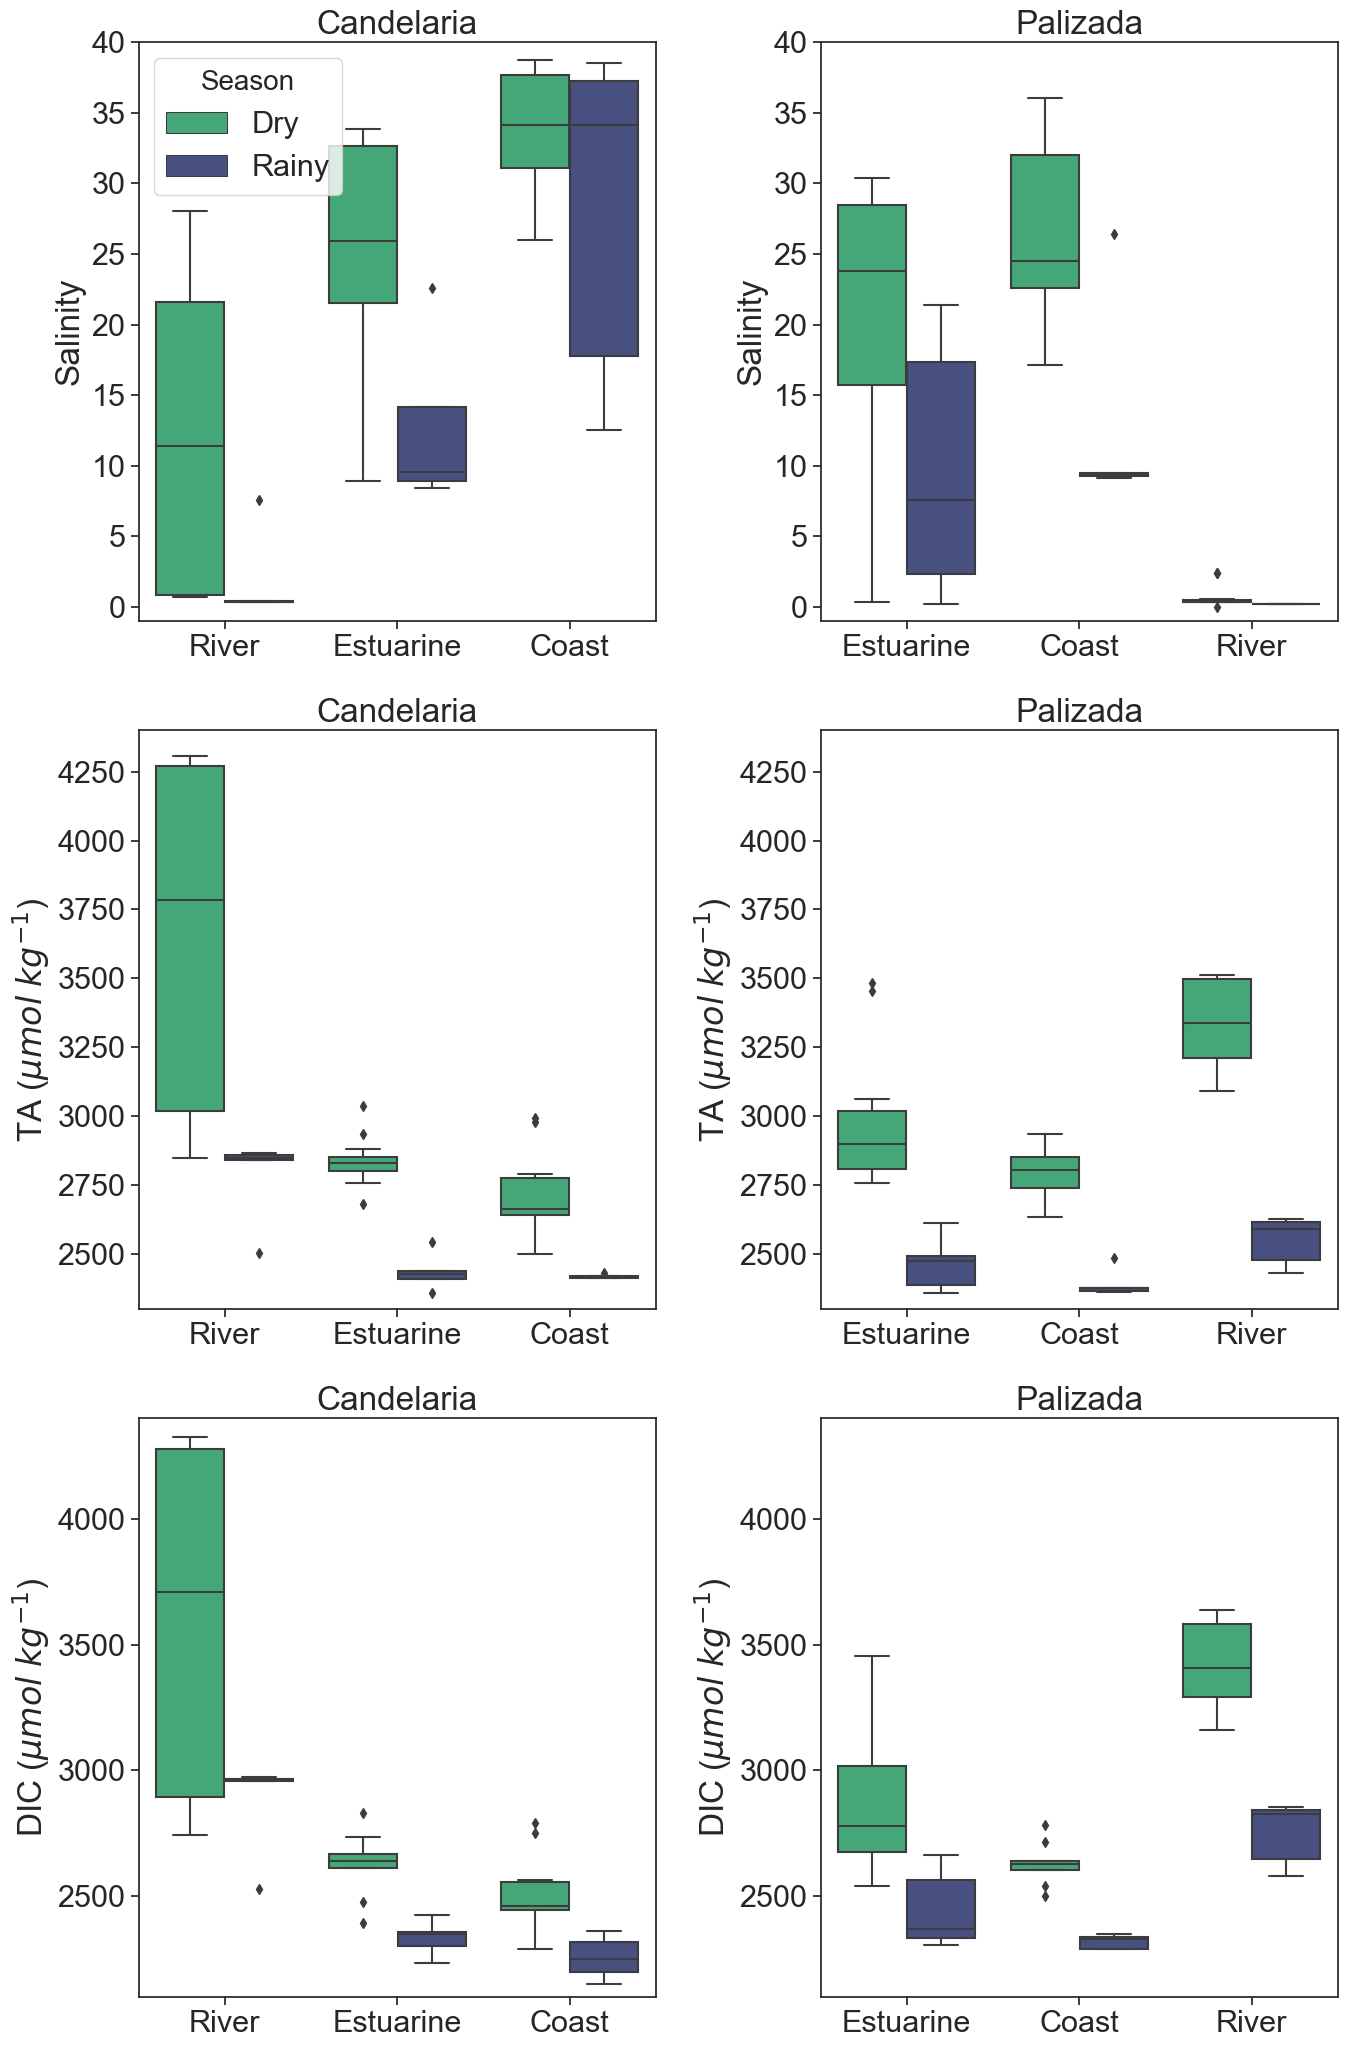

In [14]:
# Export the plot  measuring variables

plot_variables(CarbonateTL, measured_variables_dict)

plt.savefig("../output_files/02_Fig2.pdf", format='pdf')



In [15]:
# calcuated carbonate variables dictionary for plotting
carbonate_variables_dict = {
    "pCO2_atm" : {
    "display_name": f' $pCO_{2}$ $(\mu atm)$',
    "min": 400,
    "max": 8500
    },
    "pH": {
        "display_name": "pH",
        "min": 7.25,
        "max": 8.5
        }, 
    "saturation_aragonite": {
        "display_name": r'$\Omega_{ar}$',
        "min": -0.1,
        "max": 5
        },
    "TA-DIC": {
        "display_name": f'[TA-DIC] ($\mu mol \; kg^{{-1}}$)',
        "min": -280,
        "max": 350
    }        
}

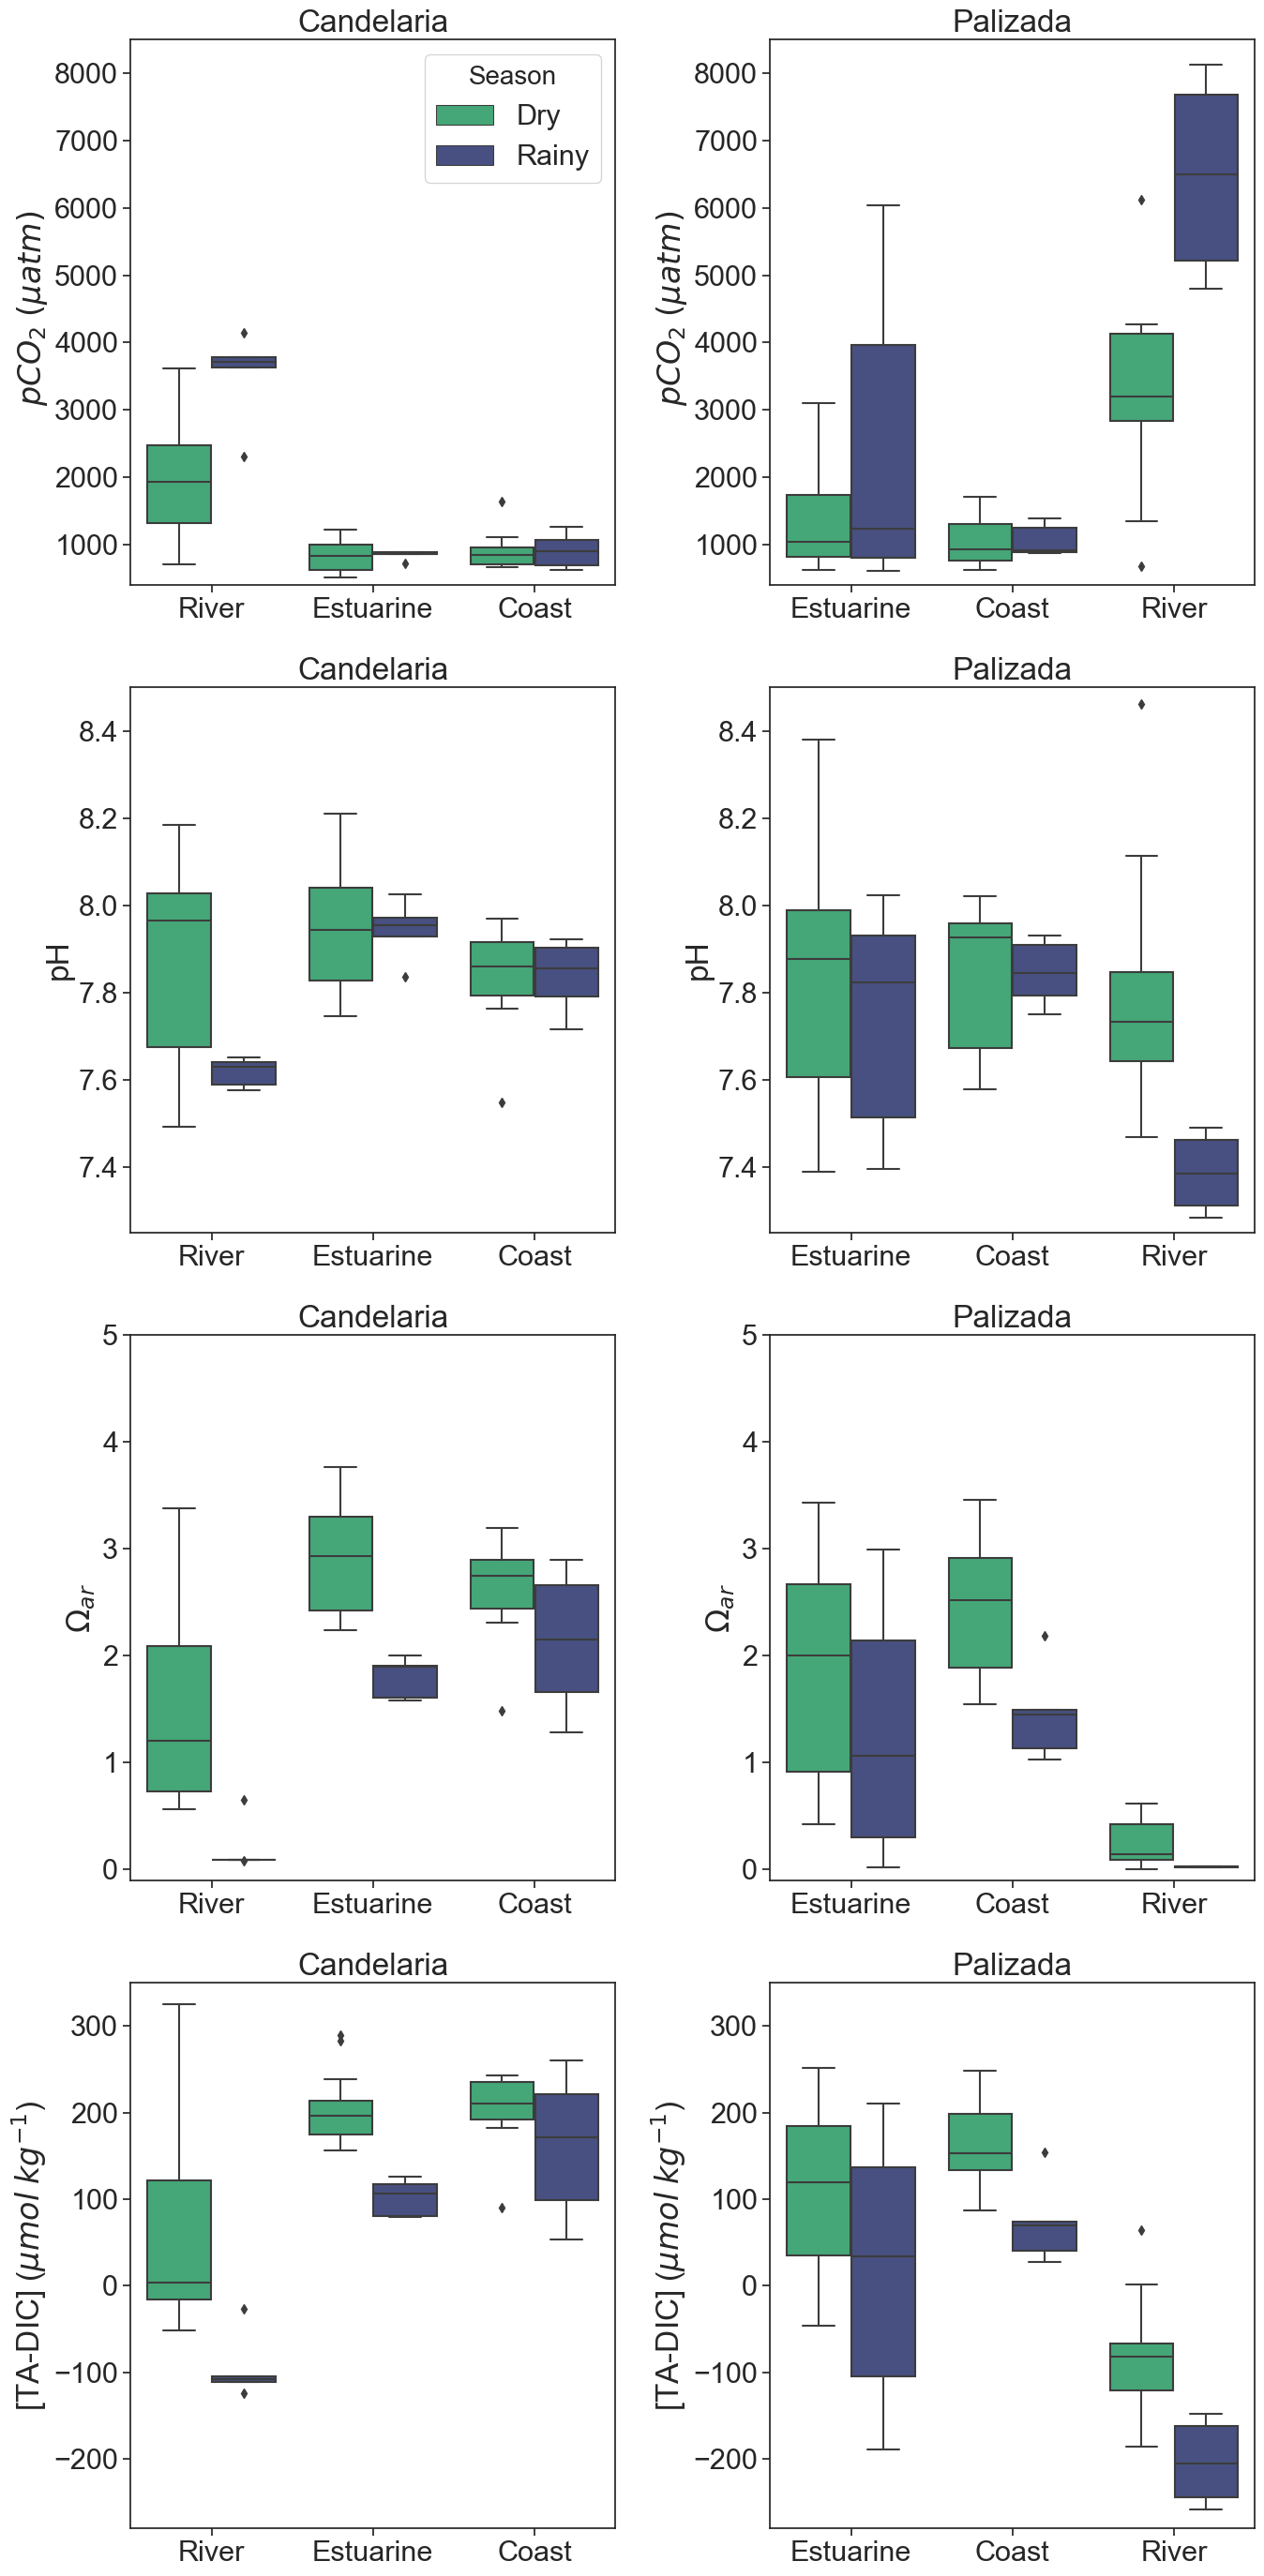

In [16]:
plot_variables(CarbonateTL, carbonate_variables_dict)

plt.savefig("../output_files/02_Fig2.pdf", format='pdf')